In [1]:
%matplotlib inline

In [3]:
# imports
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("../Bootstrap/py"))
import qpq9_boot as qpq9b
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


## Load stack_tup

In [4]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),
                               vsig_cut=400*u.km/u.s,plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if (('J0143+2954' in idict['qpq']['NAME']) or ('J0850+4755' in idict['qpq']['NAME']) or 
        ('J0951+4932' in idict['qpq']['NAME'])): # removing bad continua that gave fake S/N 
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ003423.40-104956.3_b1200_F.fits.gz for BOSSJ0034-1049
S/N in rest frame: 27.395062906 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6267-56279-0926.fits.gz for SDSSJ0143+2954
S/N in rest frame: 6.33441423372 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
No spectrum found for SDSSJ0233

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:249: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:974: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)



Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ123141.73+002913.9_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N in rest frame: 78.1900954682 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
No continuum: spec-7416-56810-0860.fits.gz
No spectrum found for SDSSJ1253+4751 and wvobs=3783.95 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ130603.55+615835.2_b1200_F.fits.gz for APOJ1306+6158
S/N in rest frame: 32.2260362938 1 / Angstrom
Database is QPQ
Created on 2017-Ja

In [5]:
print(np.sum(stck_mskN,0))
sv_zfg = []
sv_Rperp = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(idict['qpq']['Z_FG'])
    sv_Rperp.append(idict['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

[ 40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.]


(2.0403179994907807, 156.84979321442023)

## Stack and Plot

### Mean

In [6]:
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Median

In [7]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write 

In [8]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zIRMgII_1334_mean.fits'
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zIRMgII_1334_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zIRMgII_1334_mean.fits
Wrote spectrum to Output/QPQ9_zIRMgII_1334_med.fits


## Bootstrap

In [9]:
#Mean 
reload(qpq9b)
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/IRMgII_1334_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.50586, Median=0.486826, std=0.263937 for Ntrials=10000
Centroid: Mean = 213.108, scatter=98.1288
Dispersion and scatter of it:  304.586128413 87.2265683381
max and min centroid:  542.679429325 -386.335234484
Wrote ../Bootstrap/Output/IRMgII_1334_mean.fits


In [10]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1334_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

In [11]:
# Plot centroids
tau_cen = hdulist[3].data
n,bins,patches = plt.hist(tau_cen,50,normed=1,facecolor='green',alpha=0.5)
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

0.0349

In [12]:
# Plot dispersions
tau_disp = hdulist[4].data
n,bins,patches = plt.hist(tau_disp,50,normed=1,facecolor='green',alpha=0.5)
plt.xlabel('Dispersion (km/s)')
plt.ylabel('Probability')

In [13]:
#Median
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/IRMgII_1334_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.40453, Median=0.39546, std=0.336506 for Ntrials=10000
Centroid: Mean = 114.082, scatter=240.321
Dispersion and scatter of it:  256.877289682 568.526109526
max and min centroid:  18429.3164277 -1102.28065488
Wrote ../Bootstrap/Output/IRMgII_1334_med.fits


In [14]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1334_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# [OIII] only

In [16]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=70*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),
                              plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1508+3635' in dd['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ080048.74+354231.3.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N in rest frame: 91.8284865936 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ081420.38+325016.1_b1200_F.fits.gz for BOSSJ0814+3250
S/N in rest frame: 45.4033910613 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loadi

In [17]:
print(np.sum(stck_mskN,0))
sv_zfg = []
sv_Rperp = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    print(idict['qpq']['NAME'])
    sv_zfg.append(idict['qpq']['Z_FG'])
    sv_Rperp.append(idict['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

[ 15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.]
APOJ0800+3542
BOSSJ0814+3250
BOSSJ0841+3921
BOSSJ0853-0011
APOJ0932+0925
BOSSJ1039+5026
BOSSJ1144+0959
BOSSJ1204+0221
BOSSJ1215+5715
BOSSJ1231+0029
APOJ1420+1603
BOSSJ1427-0121
BOSSJ1433+0641
APOJ1553+1921
APOJ1627+4606


(2.2939547136906882, 182.69367526263065)

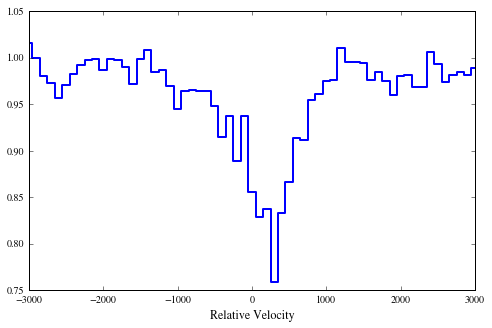

In [18]:
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

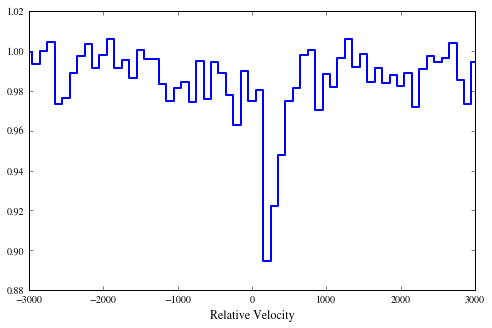

In [19]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write

In [20]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zOIII_1334_mean.fits'
relativistic_equiv = u.doppler_relativistic(1334.5323*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zOIII_1334_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zOIII_1334_mean.fits
Wrote spectrum to Output/QPQ9_zOIII_1334_med.fits


## Bootstrap

In [21]:
#Mean 
reload(qpq9b)
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/OIII_1334_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.433667, Median=0.447171, std=0.219603 for Ntrials=10000
Centroid: Mean = 224.037, scatter=118.401
Dispersion and scatter of it:  318.787626845 103.364019921
max and min centroid:  647.410152153 -312.013019069
Wrote ../Bootstrap/Output/OIII_1334_mean.fits


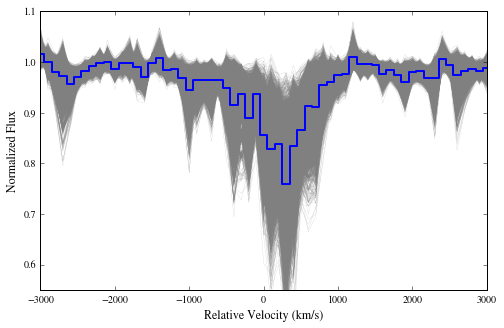

In [22]:
# plot trials
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1334_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.axis([-3000,3000,0.55,1.1])
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.0406

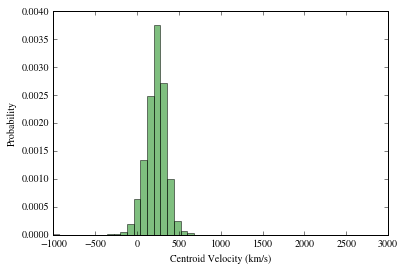

In [23]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen, 50, normed=1, facecolor='green', alpha=0.5,range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [24]:
#Median
qpq9b.boot_trans(wrest=1334.5323*u.AA,outfil='../Bootstrap/Output/OIII_1334_med.fits',stack_tup0=stack_tup,median=True,nboot=1000)

Equivalent width skewness: Mean=0.428041, Median=0.49748, std=0.475256 for Ntrials=1000
Centroid: Mean = 206.266, scatter=190.601
Dispersion and scatter of it:  204.750896108 235.817584062
max and min centroid:  728.379032689 -626.492790232
Wrote ../Bootstrap/Output/OIII_1334_med.fits


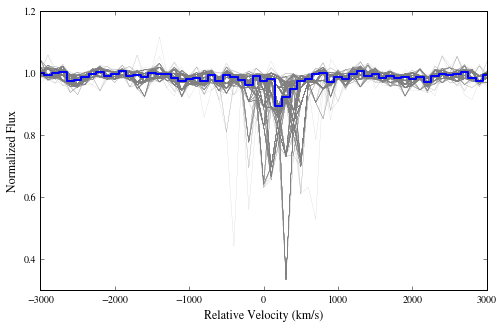

In [25]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1334_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# Plot individual spectra 

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ003423.40-104956.3_b1200_F.fits.gz for BOSSJ0034-1049
S/N in rest frame: 27.395062906 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6267-56279-0926.fits.gz for SDSSJ0143+2954
S/N in rest frame: 6.33441423372 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
No spectrum found for SDSSJ0233

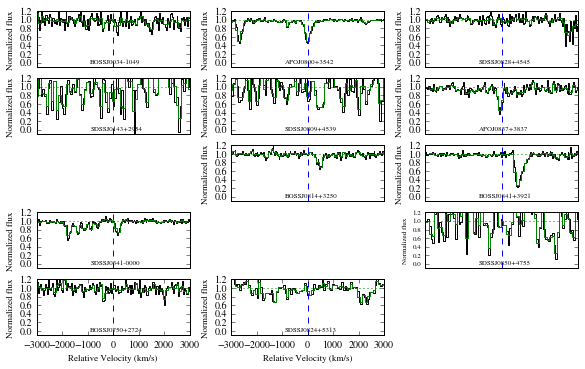

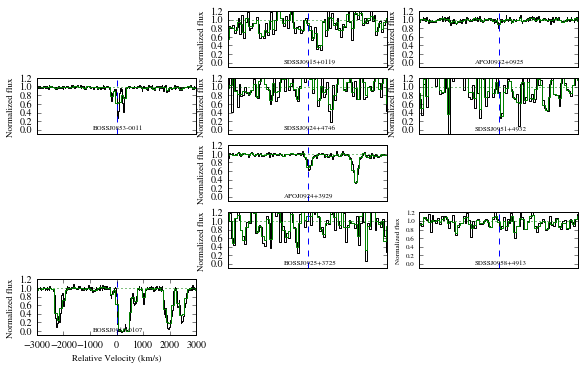

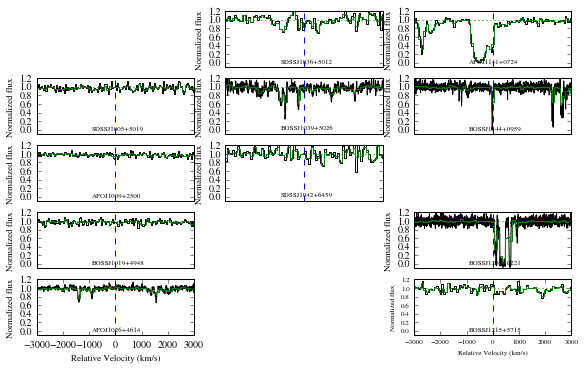

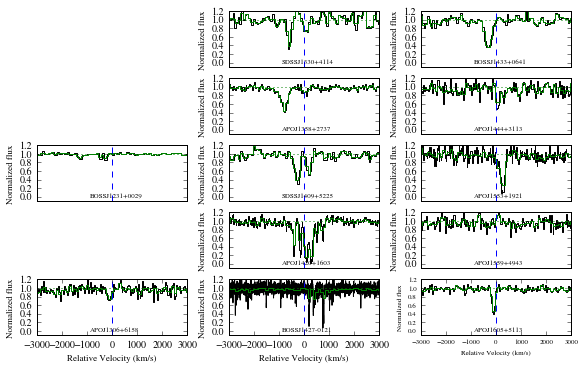

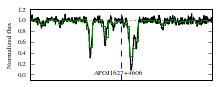

In [26]:
qpq9k.plt_qpq9(wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,stack_fg=False,zfg_mnx=(1.6,9999))

# Split in two bins of g_UV

## MgII redshift stack

x.fits.bintab_to_table: Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N in rest frame: 81.2002163512 1 / Angstrom


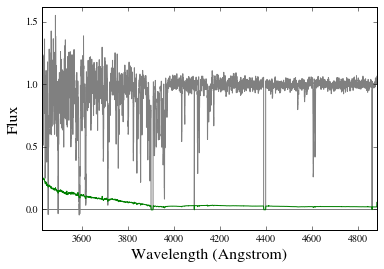

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ080048.74+354231.3.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N in rest frame: 91.8284865936 1 / Angstrom


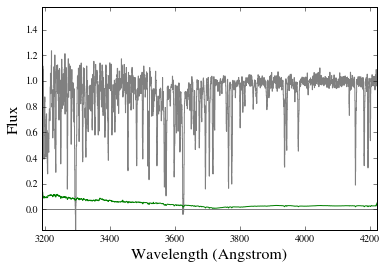

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ081420.38+325016.1_b1200_F.fits.gz for BOSSJ0814+3250
S/N in rest frame: 45.4033910613 1 / Angstrom


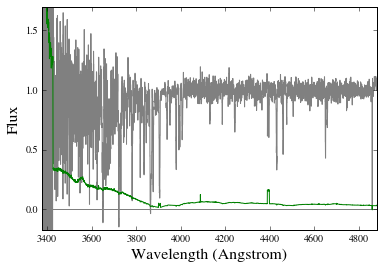

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N in rest frame: 30.3853921563 1 / Angstrom


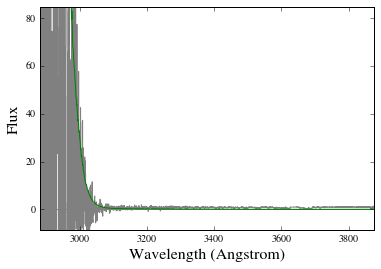

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ083757.13+383722.4_b1200_F.fits.gz for APOJ0837+3837
S/N in rest frame: 30.2325672808 1 / Angstrom


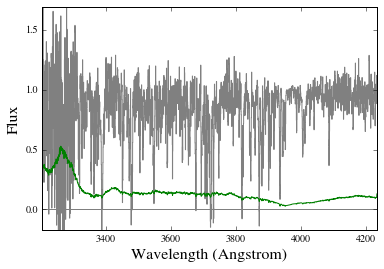

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ084159.26+392140.0.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ084159.26+392140.0_b1200_F.fits.gz for BOSSJ0841+3921
S/N in rest frame: 60.7802366381 1 / Angstrom


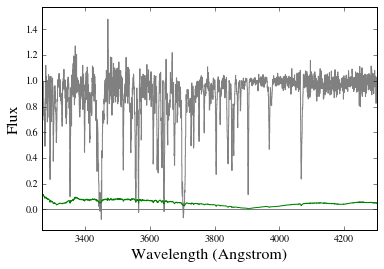

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRSPEC_redux//./SDSSJ085357.49-001106.2.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N in rest frame: 98.9152401339 1 / Angstrom


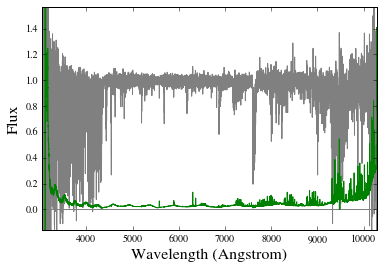

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0904+0042 and wvobs=3495.53 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ091338.97-010704.6_F.fits.gz for BOSSJ0913-0107
S/N in rest frame: 148.785541965 1 / Angstrom


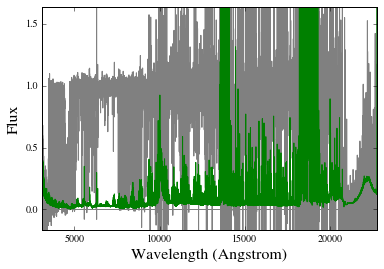

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ091553.38+011911.3.fits for BOSSJ0915+0119
S/N in rest frame: 10.8331445701 1 / Angstrom


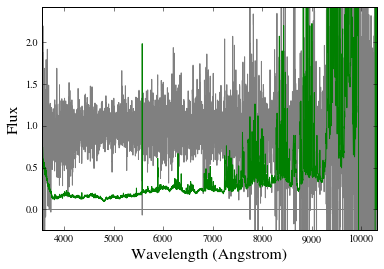

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ092416.73+392914.6_b1200_F.fits.gz for APOJ0924+3929
S/N in rest frame: 73.4837197801 1 / Angstrom


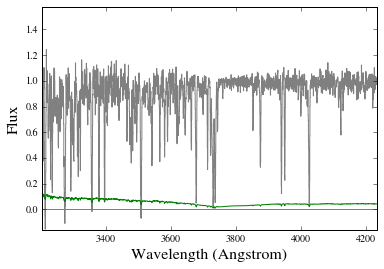

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N in rest frame: 63.0893467327 1 / Angstrom


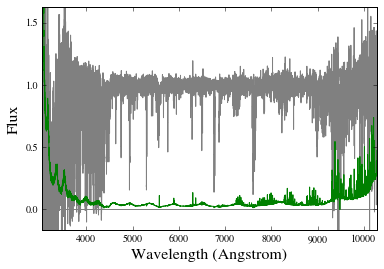

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
No spectrum found for BOSSJ1002+0020 and wvobs=4241.08 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100507.08+501929.8_b1200_F.fits.gz for SDSSJ1005+5019
S/N in rest frame: 61.1958688467 1 / Angstrom


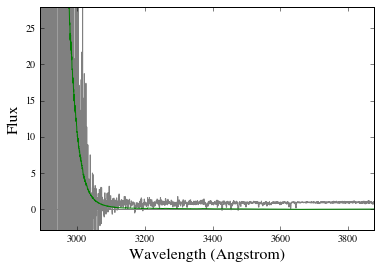

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100940.58+250053.9_b1200_F.fits.gz for APOJ1009+2500
S/N in rest frame: 57.7116647736 1 / Angstrom


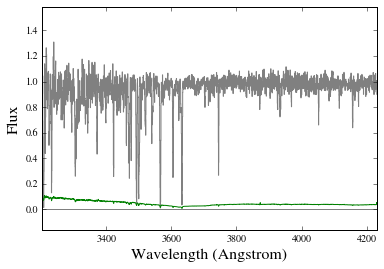

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ102616.12+461420.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ102616.12+461420.8_F.fits.gz for APOJ1026+4614
S/N in rest frame: 108.460526863 1 / Angstrom


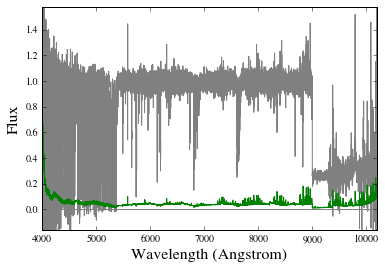

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6702-56381-0508.fits.gz for BOSSJ1036+5012
S/N in rest frame: 17.6500271638 1 / Angstrom


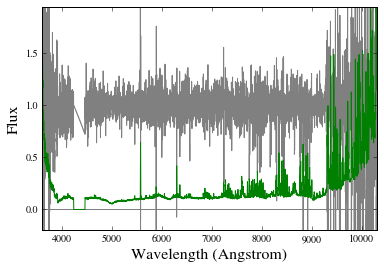

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ103900.01+502652.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N in rest frame: 56.6214986074 1 / Angstrom


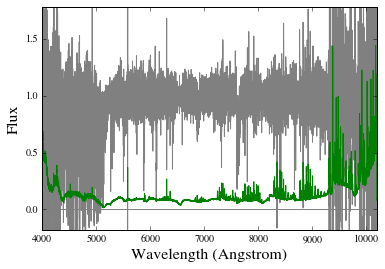

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-7083-56722-0068.fits.gz for BOSSJ1042+6459
S/N in rest frame: 12.9992594248 1 / Angstrom


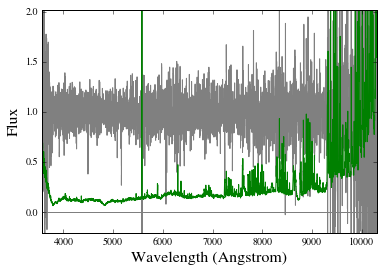

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_b400_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ114145.43+072423.3_b600_F.fits.gz for APOJ1141+0724
S/N in rest frame: 51.903728653 1 / Angstrom


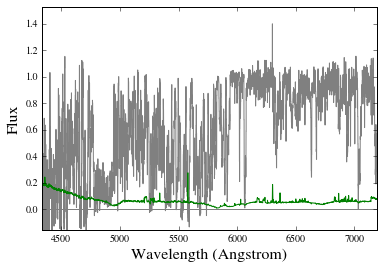

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_r_F.fits.gz for BOSSJ1144+0959
S/N in rest frame: 182.960972292 1 / Angstrom


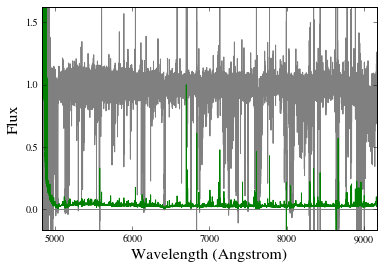

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00144 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N in rest frame: 142.737660247 1 / Angstrom


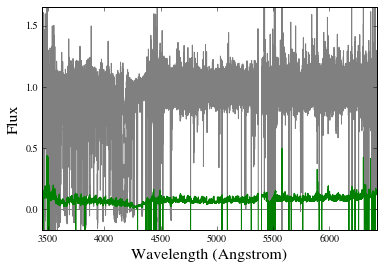

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ121558.82+571555.6.fits
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N in rest frame: 15.4003819102 1 / Angstrom


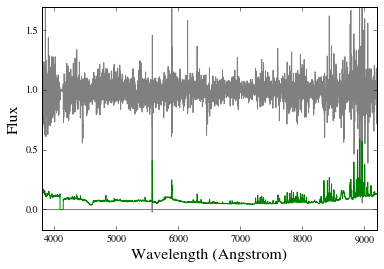

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ123141.73+002913.9_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N in rest frame: 78.1900954682 1 / Angstrom


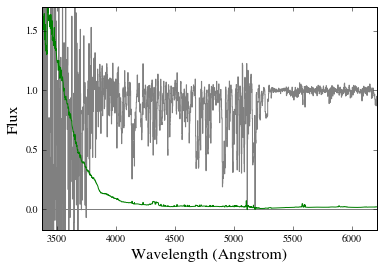

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ130603.55+615835.2_b1200_F.fits.gz for APOJ1306+6158
S/N in rest frame: 32.2260362938 1 / Angstrom


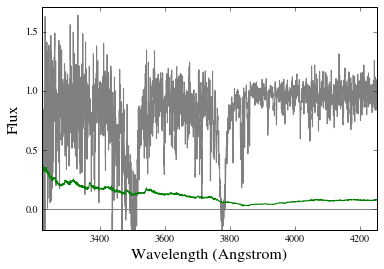

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ135849.55+273756.9_b1200_F.fits.gz for APOJ1358+2737
S/N in rest frame: 52.9957482164 1 / Angstrom


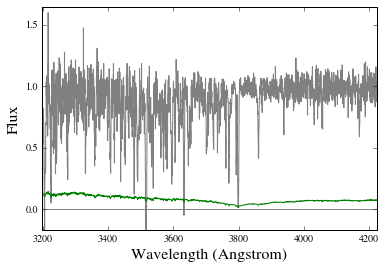

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ142054.92+160342.9.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N in rest frame: 43.9229497219 1 / Angstrom


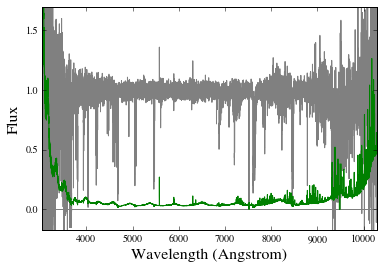

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_r_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_b_F.fits.gz for BOSSJ1427-0121
S/N in rest frame: 138.590413393 1 / Angstrom


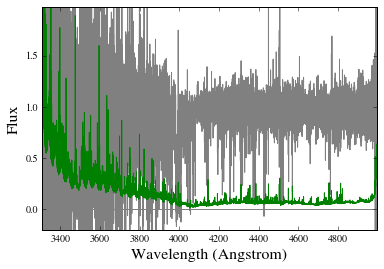

Database is QPQ
Created on 2017-Jan-31
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_7_0/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N in rest frame: 23.5414388907 1 / Angstrom


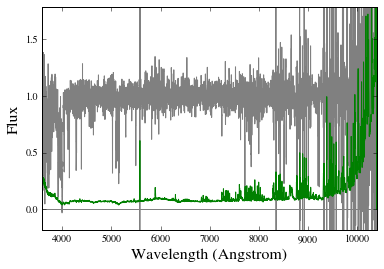

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N in rest frame: 22.1545285855 1 / Angstrom


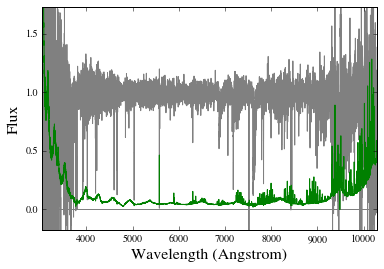

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ155946.28+494326.5_b1200_F.fits.gz for APOJ1559+4943
S/N in rest frame: 24.839736758 1 / Angstrom


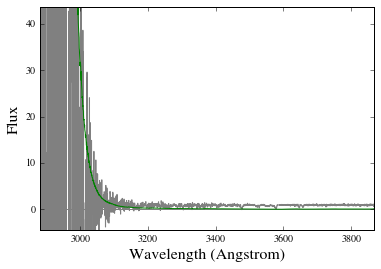

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ160546.67+511322.9_b1200_F.fits.gz for BOSSJ1605+5113
S/N in rest frame: 41.9828485416 1 / Angstrom


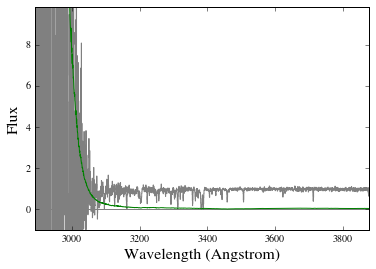

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N in rest frame: 121.115520708 1 / Angstrom


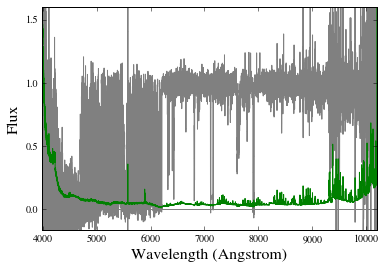

In [25]:
# Load QPQ9 data structure
enigma_path = imp.find_module('enigma')[1]
QPQ9 = xxf.bintab_to_table(enigma_path+'/data/qpq/qpq9_final.fits')
c_QPQ9 = SkyCoord(QPQ9['FG_RA']*u.deg,QPQ9['FG_DEC']*u.deg)
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

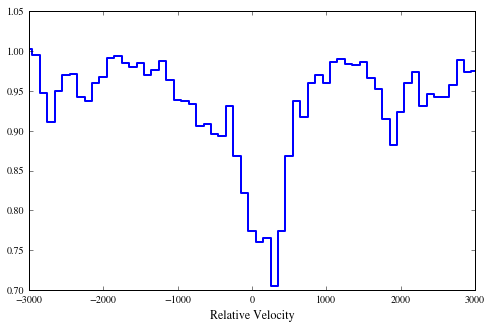

In [26]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

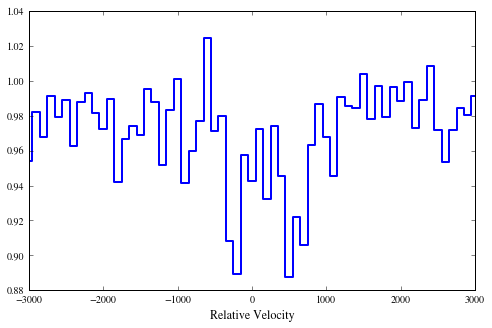

In [27]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [28]:
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits


/Users/lwymarie/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/lwymarie/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


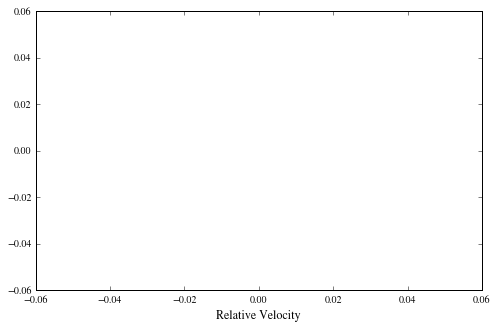

In [29]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

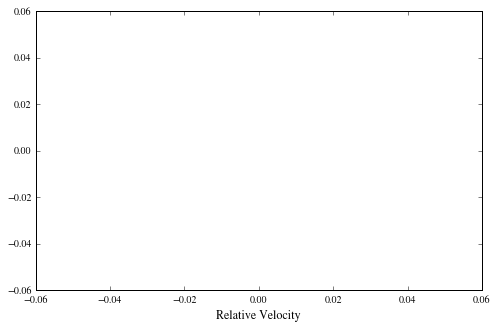

In [30]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of R_phys

## MgII redshift stack 

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N in rest frame: 81.2002163512 1 / Angstrom


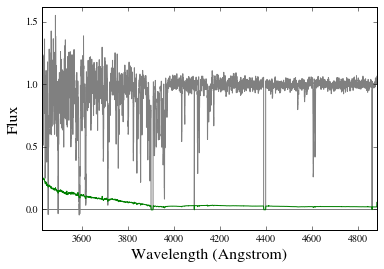

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ080048.74+354231.3.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N in rest frame: 91.8284865936 1 / Angstrom


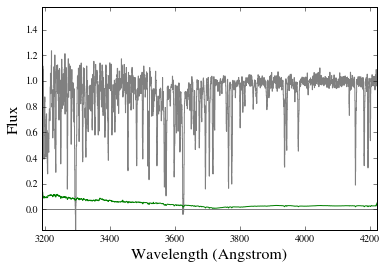

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ081420.38+325016.1_b1200_F.fits.gz for BOSSJ0814+3250
S/N in rest frame: 45.4033910613 1 / Angstrom


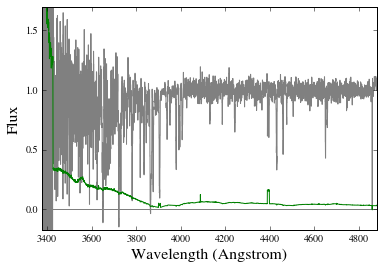

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N in rest frame: 30.3853921563 1 / Angstrom


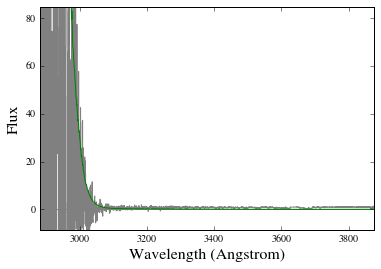

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ083757.13+383722.4_b1200_F.fits.gz for APOJ0837+3837
S/N in rest frame: 30.2325672808 1 / Angstrom


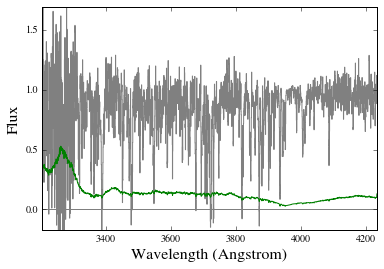

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ084159.26+392140.0.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ084159.26+392140.0_b1200_F.fits.gz for BOSSJ0841+3921
S/N in rest frame: 60.7802366381 1 / Angstrom


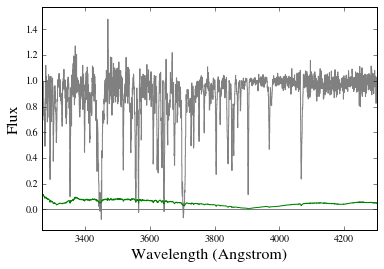

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRSPEC_redux//./SDSSJ085357.49-001106.2.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N in rest frame: 98.9152401339 1 / Angstrom


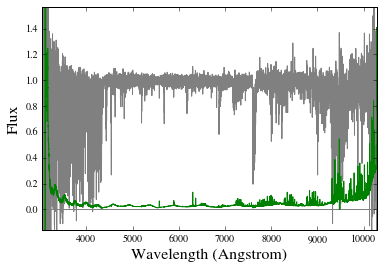

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0904+0042 and wvobs=3495.53 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ091338.97-010704.6_F.fits.gz for BOSSJ0913-0107
S/N in rest frame: 148.785541965 1 / Angstrom


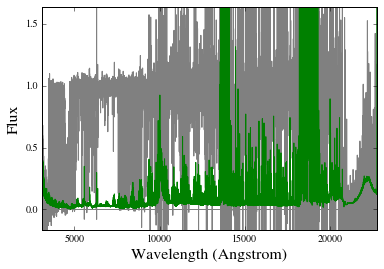

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ091553.38+011911.3.fits for BOSSJ0915+0119
S/N in rest frame: 10.8331445701 1 / Angstrom


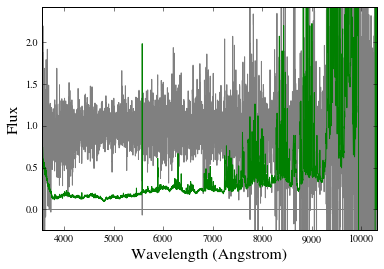

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ092416.73+392914.6_b1200_F.fits.gz for APOJ0924+3929
S/N in rest frame: 73.4837197801 1 / Angstrom


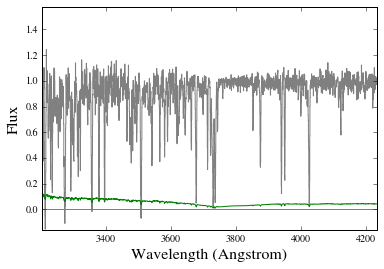

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N in rest frame: 63.0893467327 1 / Angstrom


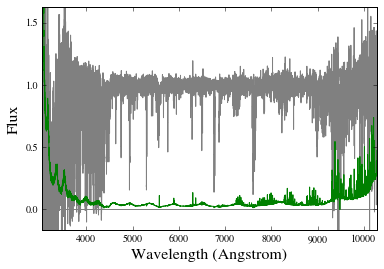

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
No spectrum found for BOSSJ1002+0020 and wvobs=4241.08 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100507.08+501929.8_b1200_F.fits.gz for SDSSJ1005+5019
S/N in rest frame: 61.1958688467 1 / Angstrom


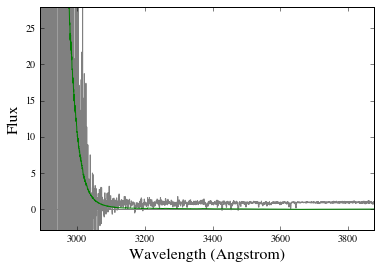

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100940.58+250053.9_b1200_F.fits.gz for APOJ1009+2500
S/N in rest frame: 57.7116647736 1 / Angstrom


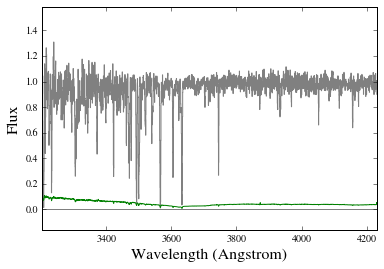

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ102616.12+461420.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ102616.12+461420.8_F.fits.gz for APOJ1026+4614
S/N in rest frame: 108.460526863 1 / Angstrom


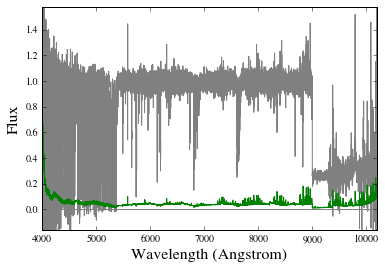

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6702-56381-0508.fits.gz for BOSSJ1036+5012
S/N in rest frame: 17.6500271638 1 / Angstrom


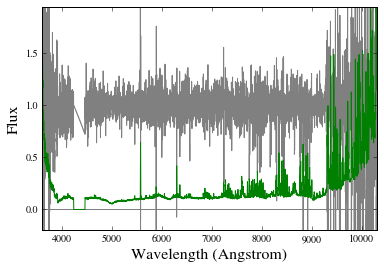

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ103900.01+502652.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N in rest frame: 56.6214986074 1 / Angstrom


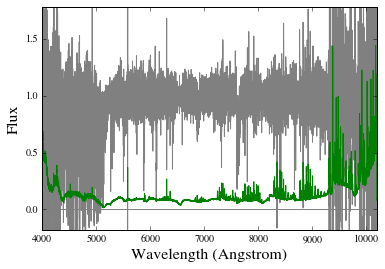

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-7083-56722-0068.fits.gz for BOSSJ1042+6459
S/N in rest frame: 12.9992594248 1 / Angstrom


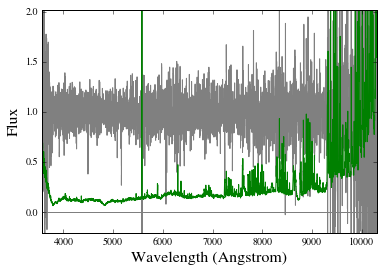

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_b400_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ114145.43+072423.3_b600_F.fits.gz for APOJ1141+0724
S/N in rest frame: 51.903728653 1 / Angstrom


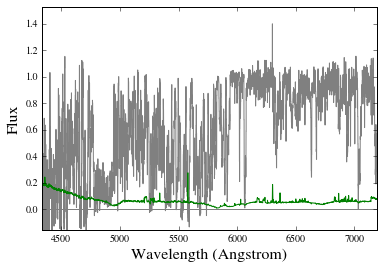

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_r_F.fits.gz for BOSSJ1144+0959
S/N in rest frame: 182.960972292 1 / Angstrom


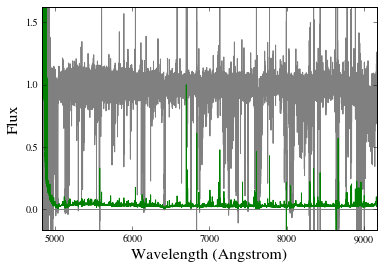

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00144 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N in rest frame: 142.737660247 1 / Angstrom


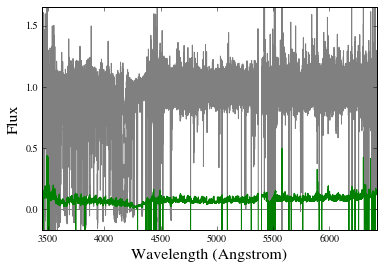

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ121558.82+571555.6.fits
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N in rest frame: 15.4003819102 1 / Angstrom


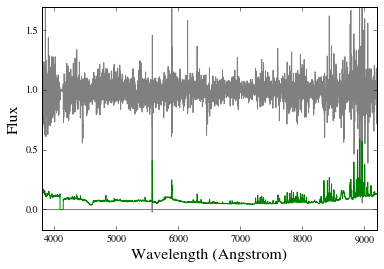

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ123141.73+002913.9_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N in rest frame: 78.1900954682 1 / Angstrom


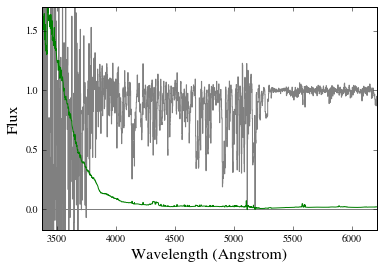

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ130603.55+615835.2_b1200_F.fits.gz for APOJ1306+6158
S/N in rest frame: 32.2260362938 1 / Angstrom


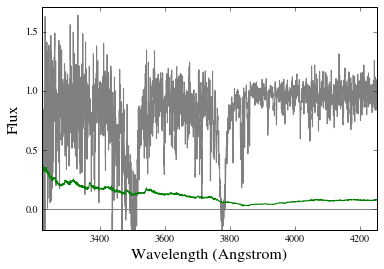

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ135849.55+273756.9_b1200_F.fits.gz for APOJ1358+2737
S/N in rest frame: 52.9957482164 1 / Angstrom


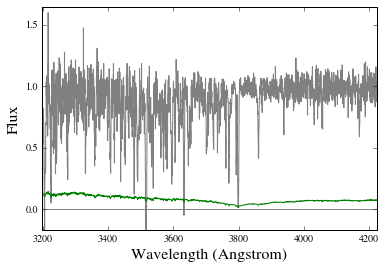

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ142054.92+160342.9.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N in rest frame: 43.9229497219 1 / Angstrom


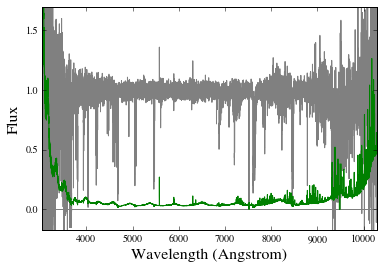

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_r_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_b_F.fits.gz for BOSSJ1427-0121
S/N in rest frame: 138.590413393 1 / Angstrom


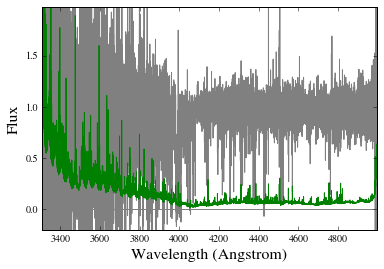

Database is QPQ
Created on 2017-Jan-31
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_7_0/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N in rest frame: 23.5414388907 1 / Angstrom


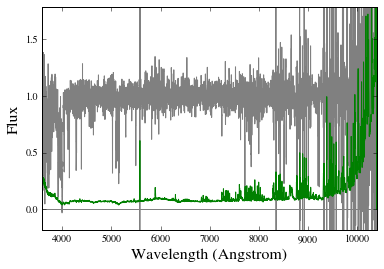

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N in rest frame: 22.1545285855 1 / Angstrom


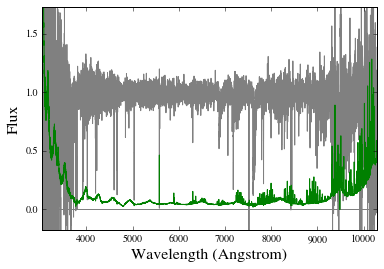

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ155946.28+494326.5_b1200_F.fits.gz for APOJ1559+4943
S/N in rest frame: 24.839736758 1 / Angstrom


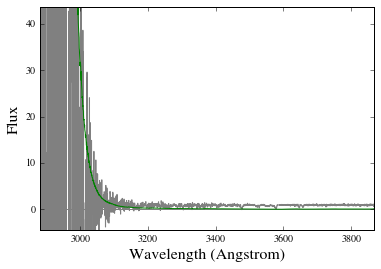

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ160546.67+511322.9_b1200_F.fits.gz for BOSSJ1605+5113
S/N in rest frame: 41.9828485416 1 / Angstrom


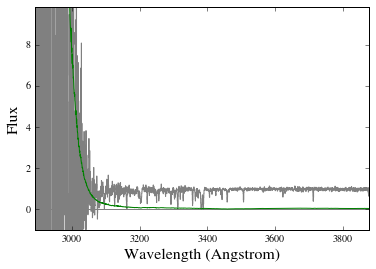

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N in rest frame: 121.115520708 1 / Angstrom


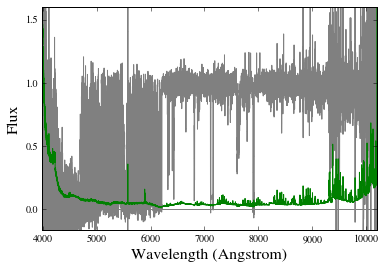

In [31]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

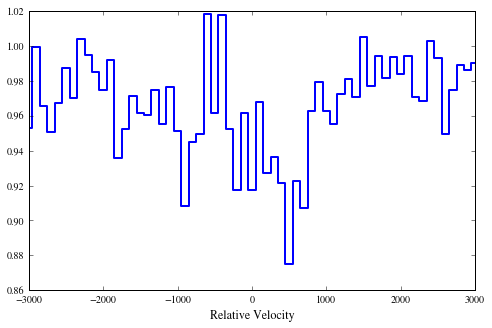

In [32]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

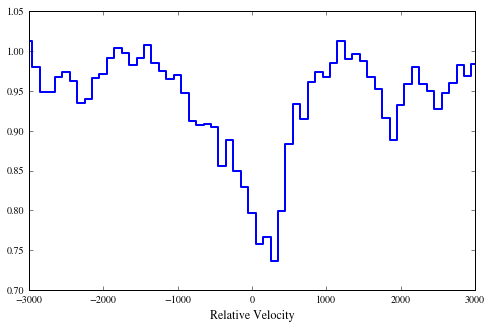

In [33]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [34]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits


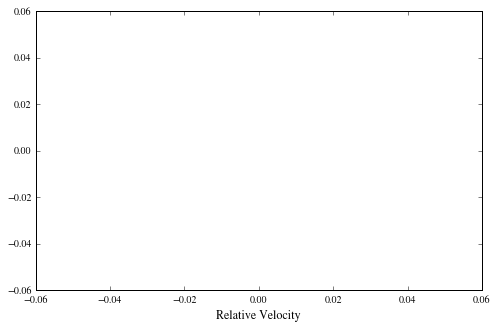

In [35]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

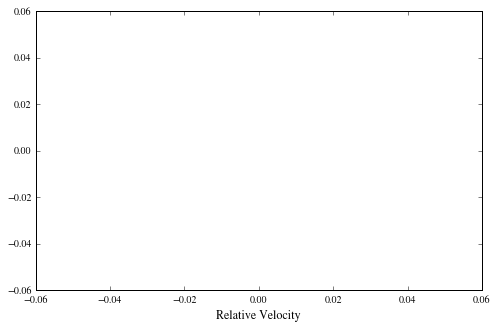

In [36]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of velocity separations 

## MgII redshift stack 

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ034139.19-000012.7_b1200_F.fits.gz for SDSSJ0341-0000
S/N in rest frame: 81.2002163512 1 / Angstrom


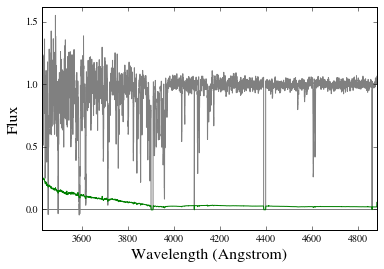

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ080048.74+354231.3.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ080048.74+354231.3_b1200_F.fits.gz for APOJ0800+3542
S/N in rest frame: 91.8284865936 1 / Angstrom


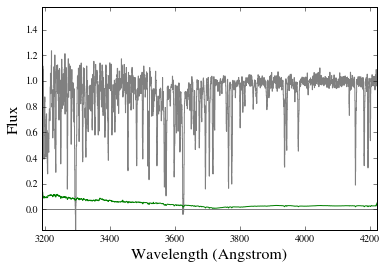

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ081420.38+325016.1_b1200_F.fits.gz for BOSSJ0814+3250
S/N in rest frame: 45.4033910613 1 / Angstrom


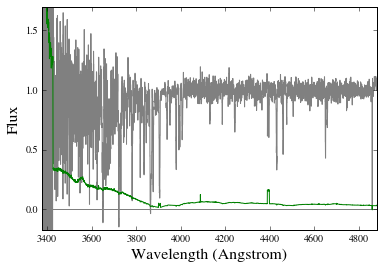

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ082844.87+454518.2_b1200_F.fits.gz for SDSSJ0828+4545
S/N in rest frame: 30.3853921563 1 / Angstrom


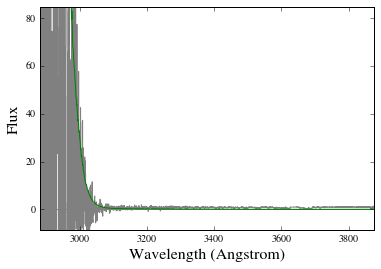

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ083757.13+383722.4_b1200_F.fits.gz for APOJ0837+3837
S/N in rest frame: 30.2325672808 1 / Angstrom


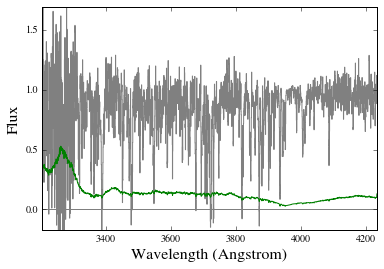

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ084159.26+392140.0.fits
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ084159.26+392140.0_b1200_F.fits.gz for BOSSJ0841+3921
S/N in rest frame: 60.7802366381 1 / Angstrom


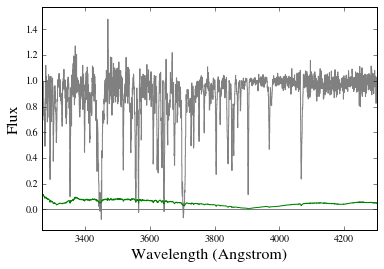

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRSPEC_redux//./SDSSJ085357.49-001106.2.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N in rest frame: 98.9152401339 1 / Angstrom


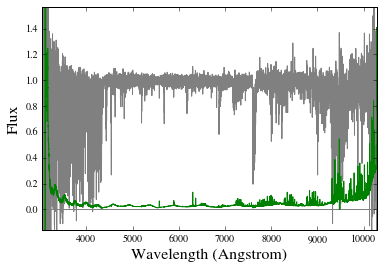

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0904+0042 and wvobs=3495.53 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ091338.97-010704.6_F.fits.gz for BOSSJ0913-0107
S/N in rest frame: 148.785541965 1 / Angstrom


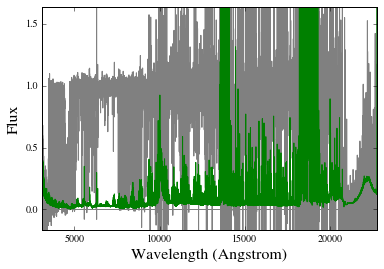

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ091553.38+011911.3.fits for BOSSJ0915+0119
S/N in rest frame: 10.8331445701 1 / Angstrom


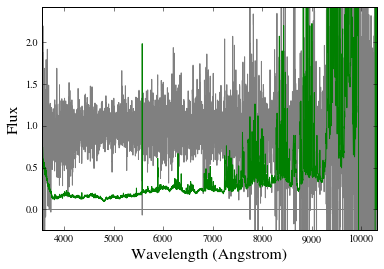

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ092416.73+392914.6_b1200_F.fits.gz for APOJ0924+3929
S/N in rest frame: 73.4837197801 1 / Angstrom


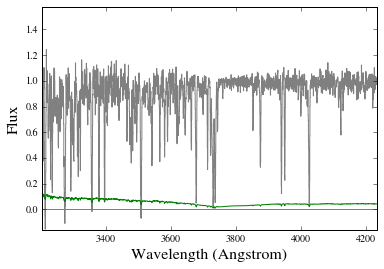

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N in rest frame: 63.0893467327 1 / Angstrom


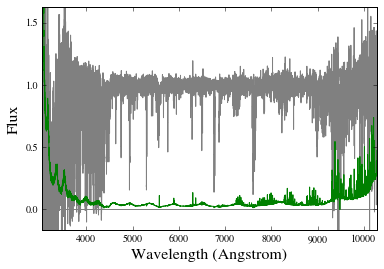

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
No spectrum found for BOSSJ1002+0020 and wvobs=4241.08 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100507.08+501929.8_b1200_F.fits.gz for SDSSJ1005+5019
S/N in rest frame: 61.1958688467 1 / Angstrom


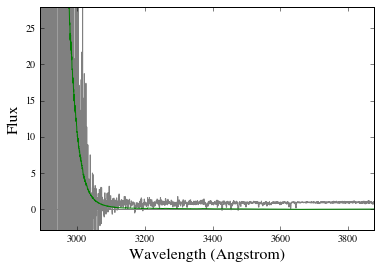

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ100940.58+250053.9_b1200_F.fits.gz for APOJ1009+2500
S/N in rest frame: 57.7116647736 1 / Angstrom


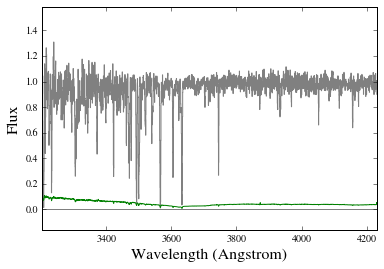

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ102616.12+461420.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ102616.12+461420.8_F.fits.gz for APOJ1026+4614
S/N in rest frame: 108.460526863 1 / Angstrom


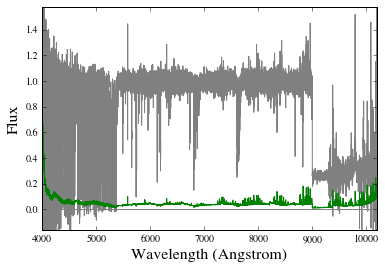

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6702-56381-0508.fits.gz for BOSSJ1036+5012
S/N in rest frame: 17.6500271638 1 / Angstrom


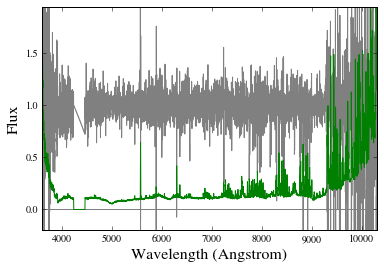

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ103900.01+502652.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N in rest frame: 56.6214986074 1 / Angstrom


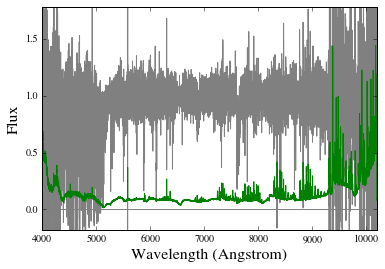

Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-7083-56722-0068.fits.gz for BOSSJ1042+6459
S/N in rest frame: 12.9992594248 1 / Angstrom


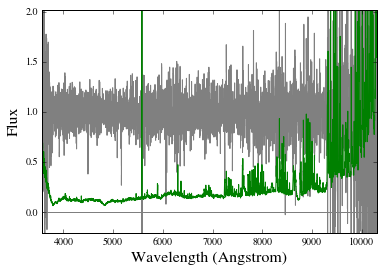

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_b400_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ114145.43+072423.3_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ114145.43+072423.3_b600_F.fits.gz for APOJ1141+0724
S/N in rest frame: 51.903728653 1 / Angstrom


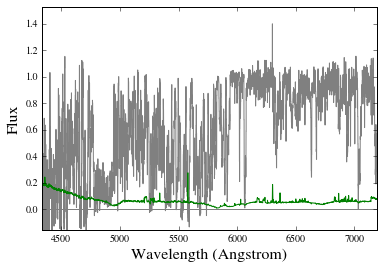

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_r_F.fits.gz for BOSSJ1144+0959
S/N in rest frame: 182.960972292 1 / Angstrom


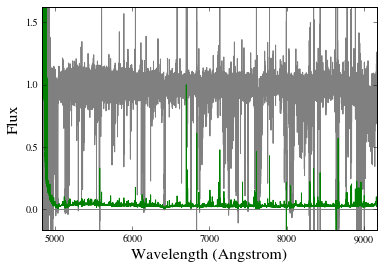

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00144 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N in rest frame: 142.737660247 1 / Angstrom


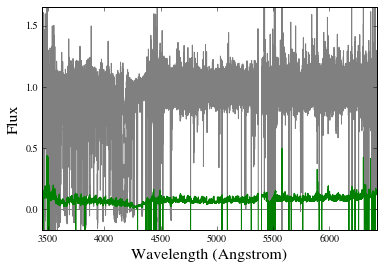

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ121558.82+571555.6.fits
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N in rest frame: 15.4003819102 1 / Angstrom


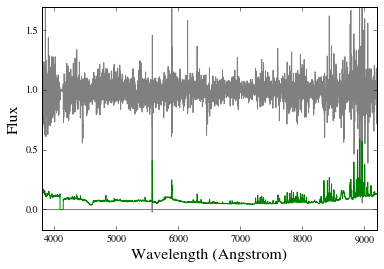

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ123141.73+002913.9_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ123141.73+002913.9_b600_F.fits.gz for BOSSJ1231+0029
S/N in rest frame: 78.1900954682 1 / Angstrom


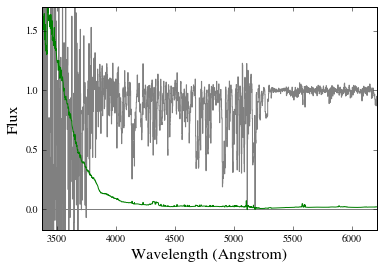

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ130603.55+615835.2_b1200_F.fits.gz for APOJ1306+6158
S/N in rest frame: 32.2260362938 1 / Angstrom


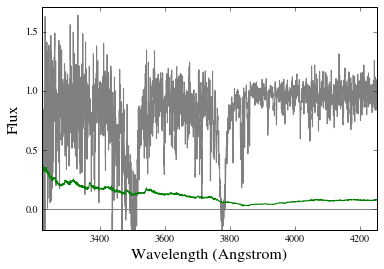

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ135849.55+273756.9_b1200_F.fits.gz for APOJ1358+2737
S/N in rest frame: 52.9957482164 1 / Angstrom


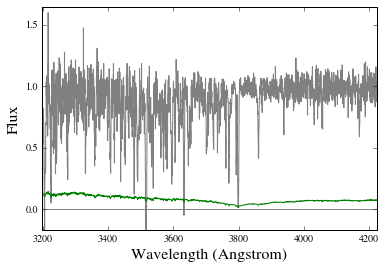

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ142054.92+160342.9.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N in rest frame: 43.9229497219 1 / Angstrom


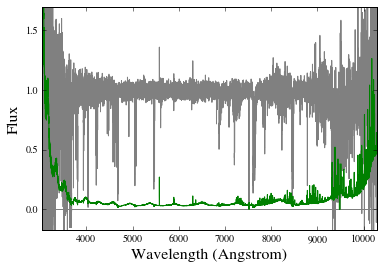

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_r_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_b_F.fits.gz for BOSSJ1427-0121
S/N in rest frame: 138.590413393 1 / Angstrom


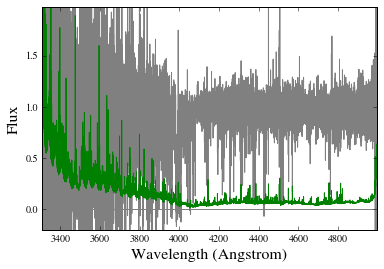

Database is QPQ
Created on 2017-Jan-31
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_7_0/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N in rest frame: 23.5414388907 1 / Angstrom


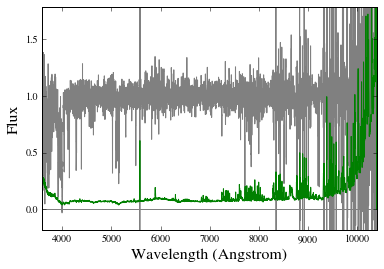

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N in rest frame: 22.1545285855 1 / Angstrom


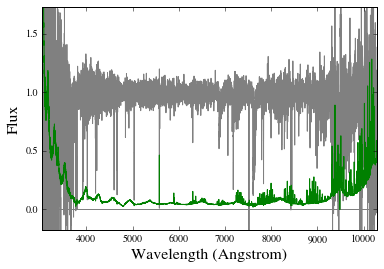

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ155946.28+494326.5_b1200_F.fits.gz for APOJ1559+4943
S/N in rest frame: 24.839736758 1 / Angstrom


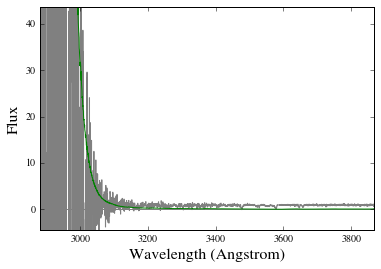

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ160546.67+511322.9_b1200_F.fits.gz for BOSSJ1605+5113
S/N in rest frame: 41.9828485416 1 / Angstrom


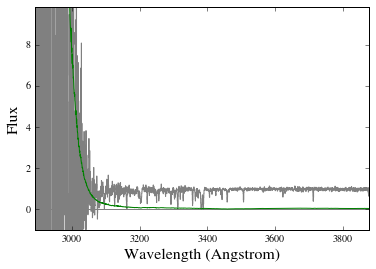

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N in rest frame: 121.115520708 1 / Angstrom


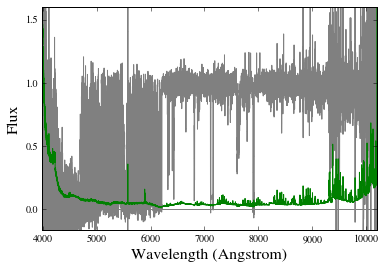

DeprecationWarning: This function is deprecated, please use dv_from_z() instead.

In [37]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),atmosphere_cut=True)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

## [OIII] redshift stack

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
print(sv_dv)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1508+3635' in idict['qpq']['NAME']: #DLA not excluded by forest cut, should be excluded now
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))